# Author : Piyush Sharma

## Perceiver IO: A General Architecture for Structured Inputs & Outputs

### TASK : Image Classification

Dataset : MNIST 

Size : 70000 Images
  
Type :  Handwritten digits grayscale images

Training Set :   `60000` images

Test Set     :   `10000` images

Image Size :     `28 x 28 x 1`

No. of Classes : `10`

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Import libraries

In [29]:
import matplotlib.pyplot as plt
import os,sys
import numpy as np
from tqdm.notebook import tqdm

import torch
from torch.optim import Adam
from torch.optim import AdamW
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ExponentialLR
from torch import nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from PIL import Image
to_pil = transforms.ToPILImage()

print("Torch version:", torch.__version__) 

Torch version: 1.10.0+cu111


In [30]:
modelname="PIOImgMnist"

prefix='/content/drive/MyDrive/Colab Notebooks/Perceiver/' + modelname +'/'

try:
    os.mkdir(prefix)
except FileExistsError:
    pass

prefix_images=prefix+'images/'
try:
    os.mkdir(prefix_images)
except FileExistsError:
    pass

prefix_metrics=prefix+'metrics/'
try:
    os.mkdir(prefix_metrics)
except FileExistsError:
    pass

prefix_models=prefix+'models/'
try:
    os.mkdir(prefix_models)
except FileExistsError:
    pass

prefix_states=prefix+'states/'
try:
    os.mkdir(prefix_states)
except FileExistsError:
    pass

In [31]:
!git clone https://github.com/Piyush9323/perceiver-pytorch
!cd perceiver-pytorch/
!pip install perceiver-pytorch

os.chdir(prefix)

fatal: destination path 'perceiver-pytorch' already exists and is not an empty directory.


#HyperParameters

In [41]:
im_res=28    #Image resolution
numchannel=1 #Input image channels
dim_=1       #Ouput image channels, 1 because this is classification

autoload=True          #Autoload selection

batch_size_train = 64  #Batch size for train
batch_size_test = 100 #Batch size for test

Load dataset and Setup dataloaders

In [33]:
transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))])

train_set = datasets.MNIST(prefix+'/data/', train=True,
                           download=True,transform=transform)

trainset, valset = random_split(train_set, [50000, 10000],
                                generator=torch.Generator().manual_seed(42))

trainloader = DataLoader(trainset, batch_size=batch_size_train,
                                          shuffle=True, num_workers=2)

valloader = DataLoader(valset, batch_size=batch_size_test,
                                          shuffle=True, num_workers=2)

testset = datasets.MNIST(prefix+'/data/', train=False,
                                          download=True,transform=transform)

testloader = DataLoader(testset, batch_size=batch_size_test,
                                          shuffle=True, num_workers=2)


print('----------------------***------------------------------')

print ("Number of training batches = ", len(trainloader), "batch size = ", batch_size_train, "total = ",len(trainloader)*batch_size_train)
print ("Number of validation batches = ", len(valloader), "batch size = ", batch_size_test, "total = ",len(valloader)*batch_size_test)
print ("Number of test batches = ", len(testloader), "batch size = ", batch_size_test, "total = ",len(testloader)*batch_size_test)

print("TOTAL images (account for full batches): ", len(trainloader)*batch_size_train+len(testloader)*batch_size_train )
 
classes = testloader.dataset.classes
nclasses=len(classes)

print("Total classes: ",nclasses)
print(classes)

----------------------***------------------------------
Number of training batches =  782 batch size =  64 total =  50048
Number of validation batches =  100 batch size =  100 total =  10000
Number of test batches =  100 batch size =  100 total =  10000
TOTAL images (account for full batches):  56448
Total classes:  10
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


Display sample image

(28, 28)


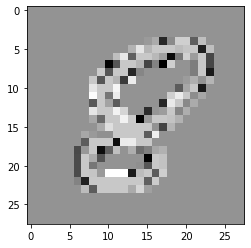

In [34]:
input=next(iter(testloader))[0]
image = to_pil(input[0])
print(image.size)
plt.imshow(image,cmap='gray')
plt.show()

Set device

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Build Model

In [40]:
from perceiver_pytorch import PerceiverIO
model = PerceiverIO(
    dim = im_res*im_res*numchannel,   # dimension of sequence to be encoded
    queries_dim = 32,            # dimension of decoder queries
    logits_dim = nclasses,       # dimension of final logits
    depth = 6,                   # depth of net
    num_latents = 256,           # number of latents
    latent_dim = 512,            # latent dimension
    cross_heads = 1,             # number of heads for cross attention.
    latent_heads = 8,            # number of heads for latent self attention,
    cross_dim_head = 64,         # number of dimensions per cross attention head
    latent_dim_head = 64,        # number of dimensions per latent self attention head
    weight_tie_layers = False    # whether to weight tie layers 
)
model.to(device)

PerceiverIO(
  (cross_attend_blocks): ModuleList(
    (0): PreNorm(
      (fn): Attention(
        (to_q): Linear(in_features=512, out_features=64, bias=False)
        (to_kv): Linear(in_features=784, out_features=128, bias=False)
        (to_out): Linear(in_features=64, out_features=512, bias=True)
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (norm_context): LayerNorm((784,), eps=1e-05, elementwise_affine=True)
    )
    (1): PreNorm(
      (fn): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=512, out_features=4096, bias=True)
          (1): GEGLU()
          (2): Linear(in_features=2048, out_features=512, bias=True)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
  )
  (layers): ModuleList(
    (0): ModuleList(
      (0): PreNorm(
        (fn): Attention(
          (to_q): Linear(in_features=512, out_features=512, bias=False)
          (to_kv): Linear(in_features=512, out_featu

Current GPU information

In [16]:
!nvidia-smi 

Mon Apr 25 09:04:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    71W / 149W |    629MiB / 11441MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Function for saving trained model

In [17]:
def save_model(model_path,model,optimizer,scheduler,epoch):
    torch.save({
            'last_epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler' : scheduler.state_dict()
            },model_path)

### Function for loading pre-trained model for resuming training or for inference

In [18]:
def load_model(model_path,model,optimizer,scheduler):
    checkpoint = torch.load(model_path)
    last_epoch = checkpoint['last_epoch']
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler'])
    return last_epoch, model, optimizer, scheduler

### Setting Loss function, Optimiser and Schedular

In [19]:
lr = 0.0001
decay_rate = 0.9

#criterion =  nn.MSELoss()
#lmbda = lambda epoch: 0.5 if (epoch<2) else (0.01 if epoch==2 else 1)

criterion =  nn.MSELoss()
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = ExponentialLR(optimizer, gamma=decay_rate,verbose=True)
#scheduler = MultiStepLR(optimizer, milestones=[1,2,3,4], gamma=0.5)
    

Adjusting learning rate of group 0 to 1.0000e-04.


### Load pre-trained saved model if available

In [38]:
if autoload:
    directory=os.listdir(prefix_states)
    maxepoch=0
    for item in directory:
        #print(item)
        if "pt" in item:
            num=int(item.split(".")[0].split("_")[2])
            #print(num)
            if num>maxepoch:
                maxepoch=num
                
    if maxepoch==0:
        startepoch=1
    else:
        model_path = f"{prefix_states}state_epoch_{maxepoch}_{lr}.pt"
        last_epoch, model, optimizer, scheduler = load_model(model_path,model,optimizer,scheduler)
        startepoch = last_epoch+ 1
        print(f"Pre-trained model loaded from {model_path}")

if not autoload:
    startepoch=1
    
print(startepoch)

1


In [21]:
#Define queries
queries=torch.zeros(1,32)
queries=queries.to(device)

#Unflatten
m2 = nn.Sequential(
  nn.Unflatten (1, (dim_, im_res, im_res))
)

#Flattening function
def conv_flattened_to_image_ind (inputs):
    outputs_for_image= torch.clone  (inputs)
    outputs_for_image=torch.permute(outputs_for_image, (0,2,1)  )
    outputs_for_image=torch.flatten(outputs_for_image, start_dim=1, end_dim=2)
    outputs_for_image = m2(outputs_for_image)

    return outputs_for_image


In [22]:
#find learning rate
def get_lr(optimizer):
    return optimizer.param_groups[0]["lr"]

### Training

In [42]:
torch.cuda.empty_cache()
epochs = 35

for epoch in range(startepoch, epochs+1):
    print(f"Epoch {epoch}/{epochs}")
    learning_rate = get_lr(optimizer)
    print(f'learning rate  = {learning_rate}')

    batch_count_train, batch_count_test = 0, 0
    running_loss_train, running_loss_val, running_accuracy_val = 0.0, 0.0, 0.0

    for inputs, labels in tqdm(trainloader):

        #Permute input
        inputs=torch.permute(inputs, (0,2,3,1))
        
        #One-hot encode labels
        labels=F.one_hot(labels,num_classes=nclasses)
        labels.unsqueeze_(1)

        #Reset gradients
        optimizer.zero_grad()
        
        #Flatten inputs
        inputs=torch.flatten(inputs, start_dim=1, end_dim=3)
        inputs.unsqueeze_(1)
        
        #Move inputs/labels to device
        inputs,labels = inputs.to(device),labels.to(device)

        #Run model, with inputs and queries as input
        outputs=model(inputs,queries=queries)

        #Get loss
        loss = criterion(outputs.float(), labels.float())

        running_loss_train += loss.item()
        batch_count_train += 1

        #Backpropogate loss
        loss.backward()

        #Step optimizer
        optimizer.step()


    #Set model into eval mode
    model.eval()
    
    print("\nNow evaluate test batches...")
    with torch.no_grad():
        for inputs, labels  in tqdm(valloader):
            #Clone labels
            labels_=labels.clone()
            #Permute input
            inputs=torch.permute(inputs, (0,2,3,1)  )
            
            #One-hot encode labels
            labels=F.one_hot(labels,num_classes=nclasses)
            labels.unsqueeze_(1)

            #Reset gradients
            optimizer.zero_grad()
            
            #Flatten inputs
            inputs=torch.flatten(inputs, start_dim=1, end_dim=3)
            inputs.unsqueeze_(1)

            #Move inputs/labels/labels_ to device
            inputs,labels,labels_ = inputs.to(device),labels.to(device),labels_.to(device)

            #Run model, with inputs and queries as input
            outputs=model(inputs,queries=queries )

            #Calculate test loss
            outputs_=outputs.argmax(-1).cpu().detach().numpy()
            batch_loss = criterion(outputs.float(), labels.float() ) #estimate loss for test batch

            running_loss_val += batch_loss.item()
            batch_count_test += 1
            
            #Calculate accuracy
            ps = torch.exp(outputs.squeeze()) #Squeeze used to remove dimension 1
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels_.view(*top_class.shape)

            running_accuracy_val += torch.mean(equals.type(torch.FloatTensor)).item()


    print("Validation done.")
    trainlossepoch = running_loss_train/batch_count_train
    vallossepoch = running_loss_val/batch_count_test
    valaccuracyepoch = running_accuracy_val/batch_count_test
    #valaccuracyepoch = accuracy.compute()['accuracy']

    print(f"Train loss: {trainlossepoch:.6f}\n "
            f"Test loss: {vallossepoch:.6f}\n "
            f"Accuracy: {valaccuracyepoch:.6f}"
            )
    
    #Set model into train mode
    model.train()

    #Save losses and accuracy
    with open(prefix_metrics+"train_loss_" + str(lr) + ".txt","a") as file:
        file.write(f"E{epoch}_{trainlossepoch}\n")

    with open(prefix_metrics+"val_loss_" + str(lr) + ".txt","a") as file:
        file.write(f"E{epoch}_{vallossepoch}\n")

    with open(prefix_metrics+"val_accuracy_" + str(lr) + ".txt","a") as file:
        file.write(f"E{epoch}_{valaccuracyepoch:.6f}\n")
        
    with open(prefix_metrics+"lr_" + str(lr) + ".txt","a") as file:
        file.write(f"E{epoch}_{get_lr(optimizer)}\n")

    #Step scheduler
    scheduler.step()

    #Save model for current epoch 
    state_path = prefix_states+f"state_epoch_{epoch}_{str(lr)}.pt"
    save_model(state_path,model,optimizer,scheduler,epoch)

    if(epoch==epochs):
        namesve = prefix_models+f"model_epoch_{epoch}_{str(lr)}.pth"
        torch.save(model, namesve)
    
    
print('Finished Training with lr = ',lr)

Epoch 1/35
learning rate  = 4.239115827521624e-06


  0%|          | 0/782 [00:00<?, ?it/s]

RuntimeError: ignored

Save final model

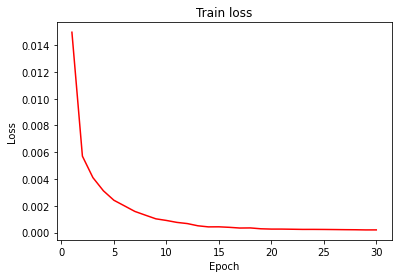

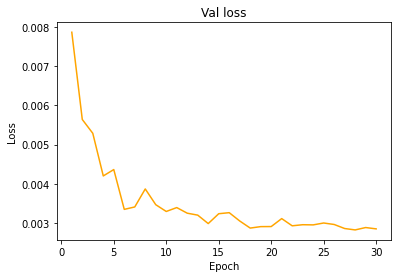

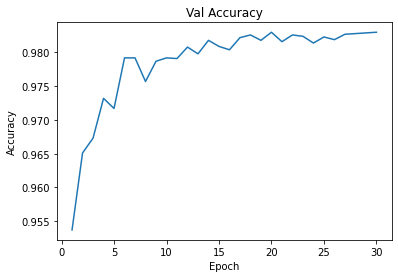

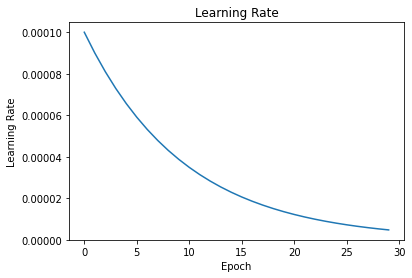

In [26]:
#Metrics
if len(os.listdir(prefix_metrics))>0:
    dir=[item for item in os.listdir(prefix_metrics) if ".txt" in item]

    with open(prefix_metrics+"train_loss_" + str(lr) + ".txt","r") as file:
        fileread=file.read().split("\n")
        fileread.pop()
        train_loss=[float(item.split("_")[1]) for item in fileread]

    with open(prefix_metrics+"val_loss_" + str(lr) + ".txt","r") as file:
        fileread=file.read().split("\n")
        fileread.pop()
        val_loss=[float(item.split("_")[1]) for item in fileread]

    with open(prefix_metrics+"val_accuracy_" + str(lr) + ".txt","r") as file:
        fileread=file.read().split("\n")
        fileread.pop()
        val_accuracy=[float(item.split("_")[1]) for item in fileread]
        
    with open(prefix_metrics+"lr_" + str(lr) + ".txt","r") as file:
        fileread=file.read().split("\n")
        fileread.pop()
        lrs=[float(item.split("_")[1]) for item in fileread]

    plt.plot(range(1,len(train_loss)+1),train_loss,color="red")
    plt.title("Train loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.savefig(prefix_metrics+"train_loss_" + str(lr) + ".png")
    plt.show()

    plt.plot(range(1, len(val_loss)+1),val_loss,color="orange")
    plt.title("Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.savefig(prefix_metrics+"Val_loss_" + str(lr) + ".png")
    plt.show()


    plt.plot(range(1, len(val_accuracy)+1),val_accuracy)
    plt.title("Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.savefig(prefix_metrics+"Val_accuracy_" + str(lr) + ".png")
    plt.show()
    
    plt.plot(range(len(lrs)),lrs)
    plt.title("Learning Rate")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.savefig(prefix_metrics+"lr_" + str(lr) + ".png")
    plt.show()

### Testing

In [ ]:
test_losses_batch, test_accuracy_batch = [], []

#Set model into eval mode
model.eval()
    
print("\nNow evaluate test batches...")
with torch.no_grad():
    for inputs, labels  in tqdm(testloader):

        #Clone labels
        labels_=labels.clone()
        
        #Permute input
        inputs=torch.permute(inputs, (0,2,3,1)  )
        
        #One-hot encode labels
        labels=F.one_hot(labels,num_classes=nclasses)
        labels.unsqueeze_(1)

        #Reset gradients
        optimizer.zero_grad()
        
        #Flatten inputs
        inputs=torch.flatten(inputs, start_dim=1, end_dim=3)
        inputs.unsqueeze_(1)

        #Move inputs/labels/labels_ to device
        inputs,labels,labels_ = inputs.to(device),labels.to(device),labels_.to(device)

        #Run model, with inputs and queries as input
        outputs=model(inputs,queries=queries )

        #Calculate test loss
        outputs_=outputs.argmax(-1).cpu().detach().numpy()
        batch_loss =   criterion(outputs.float(), labels.float() ) #estimate loss for test batch

        test_losses_batch.append(batch_loss.item())
        
        #Calculate accuracy
        ps = torch.exp(outputs.squeeze()) #Squeeze used to remove dimension 1
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels_.view(*top_class.shape)


        test_accuracy_batch.append(torch.mean(equals.type(torch.FloatTensor)).item())

testloss = sum(test_losses_batch)/len(test_losses_batch)
accuracy = sum(test_accuracy_batch)/len(test_accuracy_batch)


with open(prefix_metrics+"test_results" + str(lr) + ".txt","a") as file:
        file.write(f"Final test loss = {testloss}\n")
        file.write(f"Final test accuracy = {accuracy}\n")

print("Test loss :", testloss)
print("Accuracy on test set:", accuracy)